In [1]:
# General libraries
import pandas as pd
import numpy as np

from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
import joblib

# Utils functions
from utils.utils import kfold, read_datasets, plot_pred_expected_results

In [2]:
x_train, x_test, y_train, y_test = read_datasets(
    'x_train.csv',
    'x_test.csv',
    'y_train.csv',
    'y_test.csv'
)

In [3]:
folds = kfold()

In [4]:
# Specify range of hyperparameters to tune
hyper_params = {
    'hidden_layer_sizes': [(80,), (100,), (110,), (150,)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.0001, 0.1],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': [0.001, 0.002, 0.005, 0.006],
    'power_t': [0.5, 0.6],
    'max_iter': [200],
    'shuffle': [True],
    'momentum': [0.5, 0.8, 0.9, 1],
    'early_stopping': [False]

}



# Call RandomSearchCV()
model_cv = RandomizedSearchCV(
    estimator = MLPRegressor(),
    param_distributions = hyper_params,
    n_iter=300,
    scoring= 'r2',
    cv = folds,
    verbose = 2,
    return_train_score=True,
    n_jobs = -1,
    refit = True
    )


# Fit the model
best_model = model_cv.fit(x_train, np.ravel(y_train)) 

print(model_cv.best_params_)

Fitting 10 folds for each of 300 candidates, totalling 3000 fits


/Users/renan/Library/Python/3.7/lib/python/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ 7.15949135e-02 -2.54604898e-02 -4.64489864e-01  1.09239843e-01
  1.38147897e-01 -4.72267908e-01 -3.86983131e-01  1.01041049e-01
  1.22786060e-01  1.05587376e-01  1.03316315e-01  1.06143574e-01
             nan  9.63749254e-02  1.30843794e-02  5.14715542e-02
  1.07566823e-01 -5.01803900e-01  1.26601947e-01 -4.83153589e-01
  1.05101217e-01  1.15807280e-01             nan  9.73432500e-02
  9.91942487e-02  4.76913723e-02  1.37221398e-01  1.02565890e-01
 -2.35363544e-02  1.36750191e-02 -5.27569224e-01  1.27085291e-01
  1.23169767e-01  9.70069851e-02  1.38906308e-01  4.62581285e-03
 -2.55446576e-01  2.53684193e-02 -1.20617412e-01  9.54881282e-02
  1.51222438e-01  7.65263150e-02 -2.04641825e-01  4.50762923e-02
 -3.11632716e-01 -3.93750128e-01  6.81693540e-02  1.53203412e-01
  8.80984688e-02 -1.98086085e-01  5.03999734e-02  9.85900645e-0

{'solver': 'sgd', 'shuffle': True, 'power_t': 0.5, 'momentum': 0.5, 'max_iter': 200, 'learning_rate_init': 0.005, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (80,), 'early_stopping': False, 'alpha': 0.1, 'activation': 'tanh'}


/Users/renan/Library/Python/3.7/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [5]:
# Create new model with best_params_ from grid search

mlp_best = best_model.best_estimator_

In [6]:
# Get the results for each split

def get_best_model_cv_split_results(best_model, n_splits=10, set_type='train'):
    results = []
    best_index = best_model.best_index_
    for i in range(0, n_splits):
        current_split = 'split{}_{}_score'.format(i, set_type)
        split_result = best_model.cv_results_[current_split][best_index]
        results.append(split_result)

    return results

print("Train Results: {}".format(get_best_model_cv_split_results(best_model, 10, 'train')))
print("Test Results: {}".format(get_best_model_cv_split_results(best_model, 10, 'test')))

Train Results: [0.22319935571012395, 0.2297059825608393, 0.2444497978098812, 0.24197894252461594, 0.23543700475801854, 0.26942281521240674, 0.2415653467072887, 0.25310784807302567, 0.2466667339127332, 0.2349454178224557]
Test Results: [0.2169568647129736, 0.09950207104260023, 0.32264856989188506, 0.2577586079528028, 0.2547679977014805, -0.29724630149710185, 0.18494929898507406, 0.11079961832438334, 0.14731068736079822, 0.28395722097642584]


In [7]:
#Get the mean and std for the train and test

train_mean = sum(get_best_model_cv_split_results(best_model, 10, 'train'))/10
test_mean = sum(get_best_model_cv_split_results(best_model, 10, 'test'))/10

print("Train mean: {}".format(train_mean))
print("Train std: {}".format(np.std(get_best_model_cv_split_results(best_model, 10, 'train'))))

print("-=-=-=-=-=-=-=-=-=-=-=")

print("Validation mean: {}".format(test_mean))
print("Validation std: {}".format(np.std(get_best_model_cv_split_results(best_model, 10, 'test'))))

Train mean: 0.24204792450913892
Train std: 0.01225066742581801
-=-=-=-=-=-=-=-=-=-=-=
Validation mean: 0.15814046354513217
Validation std: 0.16718418519405331


In [8]:
y_pred = mlp_best.predict(x_test)
r2 = r2_score(y_test, y_pred)
print("The r2 score on test set: {:.4f}".format(r2))

The r2 score on test set: 0.1982


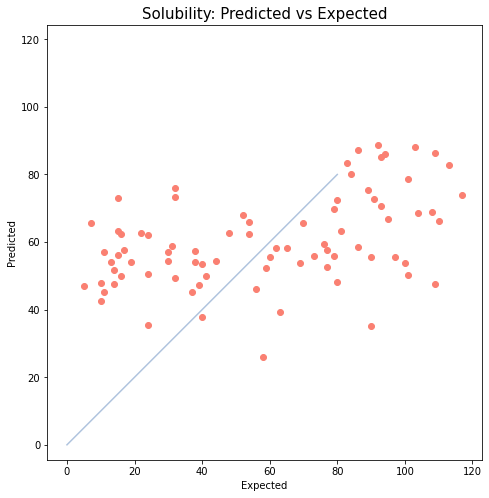

In [9]:
# Plot the R2 predicted and expected results
plot_pred_expected_results(y_test, y_pred)

# Saving trained model

In [10]:
filename = '../models/mlpRegressor_model.joblib'
joblib.dump(mlp_best, filename)

['../models/mlpRegressor_model.joblib']